In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('credit_card_fraud_dataset_modified - credit_card_fraud_dataset_modified.csv')
df.head()

,TransactionID,Amount,Time,Location,MerchantCategory,CardHolderAge,IsFraud
0,1,375.17,47605,Houston,Travel,18.0,0
1,2,950.76,38088,Los Angeles,Electronics,28.0,0
2,3,732.26,78752,Miami,Travel,20.0,0
3,4,599.06,55284,New York,Groceries,69.0,0
4,5,156.86,57043,New York,Groceries,79.0,0


In [9]:
counts = df['IsFraud'].value_counts()
percentages = df['IsFraud'].value_counts(normalize=True) * 100
print(counts)
print(percentages)


IsFraud
0    473
1     27
Name: count, dtype: int64
IsFraud
0    94.6
1     5.4
Name: proportion, dtype: float64


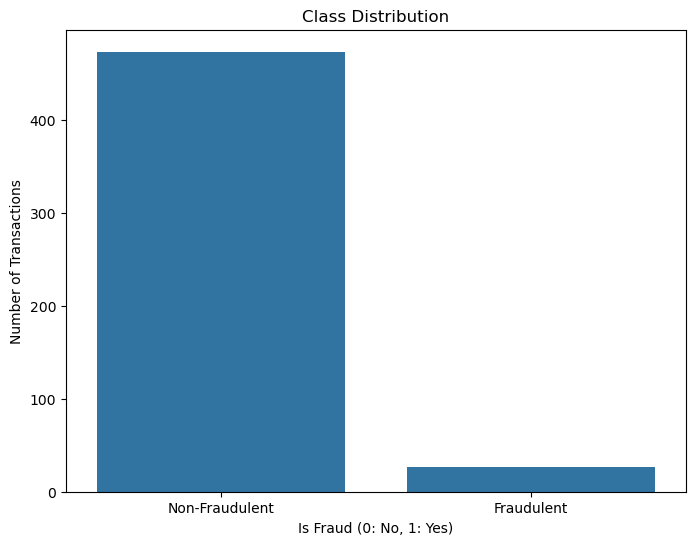

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='IsFraud', data=df)
plt.title('Class Distribution')
plt.xlabel('Is Fraud (0: No, 1: Yes)')
plt.ylabel('Number of Transactions')
plt.xticks([0, 1],['Non-Fraudulent', 'Fraudulent'])
plt.savefig('class_imbalance_plot.png')

In [26]:
df['Amount'] = df['Amount'].fillna(df['Amount'].median())
df['CardHolderAge'] = df['CardHolderAge'].fillna(df['CardHolderAge'].median())
df['MerchantCategory'] = df['MerchantCategory'].fillna(df['MerchantCategory'].mode()[0])

In [ ]:
X = df.drop('IsFraud',axis=1)
y = df['IsFraud']

In [ ]:
categorical_features = ['Location','MerchantCategory']
numerical_features = ['Amount','Time','CardHolderAge']

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'),categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42,stratify=y)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [31]:
X_train_df = pd.DataFrame(X_train_processed)
y_train_df = y_train.reset_index(drop=True)
training_data = pd.concat([X_train_df, y_train_df], axis=1)

In [32]:
processed_cols = list(range(X_train_processed.shape[1]))
training_data.columns = processed_cols + ['IsFraud']

In [33]:
majority_class = training_data[training_data['IsFraud'] == 0]
minority_class = training_data[training_data['IsFraud'] == 1]

In [ ]:
from sklearn.utils import resample

minority_oversampled = resample(minority_class,replace=True, n_samples=len(majority_class),random_state=42)

In [ ]:
oversampled_data = pd.concat([majority_class,minority_oversampled])

X_train = oversampled_data.drop('IsFraud', axis=1)
y_train = oversampled_data['IsFraud']

In [36]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC

lr_model = LR(random_state=42)
lr_model.fit(X_train, y_train)

rf_model = RFC(random_state=42)
rf_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
lr_y_pred = lr_model.predict(X_test_processed)
lr_y_pred_proba = lr_model.predict_proba(X_test_processed)[:,1]

rf_y_pred = rf_model.predict(X_test_processed)
rf_y_pred_proba = rf_model.predict_proba(X_test_processed)[:,1]

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("\nLogistic Regression Performance")
print(f"Accuracy: {accuracy_score(y_test, lr_y_pred):.4f}")
print(f"Precision: {precision_score(y_test, lr_y_pred):.4f}")
print(f"Recall: {recall_score(y_test, lr_y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, lr_y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, lr_y_pred_proba):.4f}")

print("\nRandom Forest")
print(f"Accuracy: {accuracy_score(y_test, rf_y_pred):.4f}")
print(f"Precision: {precision_score(y_test, rf_y_pred):.4f}")
print(f"Recall: {recall_score(y_test, rf_y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, rf_y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, rf_y_pred_proba):.4f}")


Logistic Regression Performance
Accuracy: 0.5600
Precision: 0.0465
Recall: 0.4000
F1-score: 0.0833
ROC AUC Score: 0.5053

Random Forest
Accuracy: 0.9400
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
ROC AUC Score: 0.3200


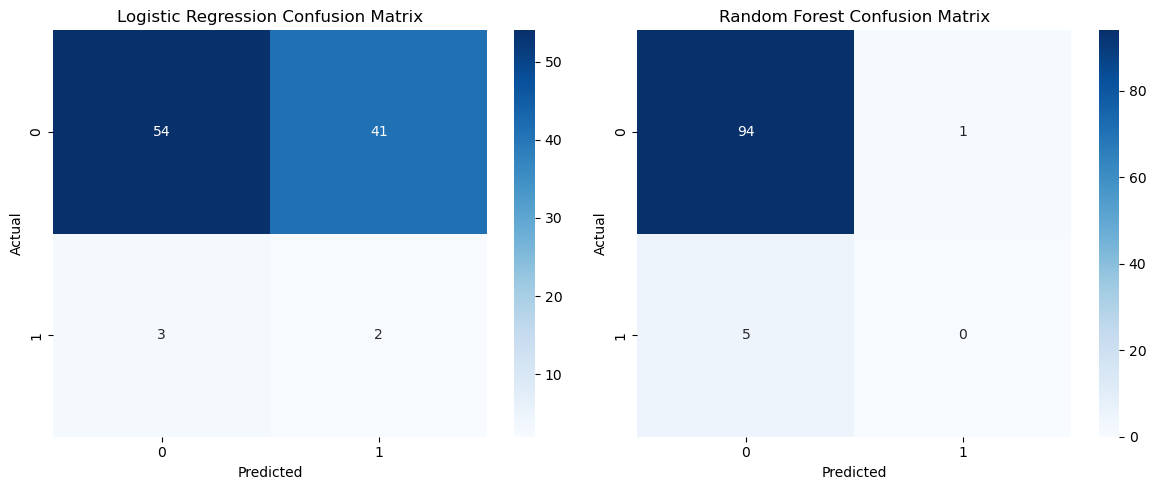

                 Model  Accuracy  Precision  Recall  F1-score   ROC AUC
0  Logistic Regression      0.56   0.046512     0.4  0.083333  0.505263
1        Random Forest      0.94   0.000000     0.0  0.000000  0.320000


In [40]:
lr_cm = confusion_matrix(y_test, lr_y_pred)
rf_cm = confusion_matrix(y_test, rf_y_pred)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices_oversampled.png')
plt.show()

performance_data_oversampled = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test, lr_y_pred), accuracy_score(y_test, rf_y_pred)],
    'Precision': [precision_score(y_test, lr_y_pred), precision_score(y_test, rf_y_pred)],
    'Recall': [recall_score(y_test, lr_y_pred), recall_score(y_test, rf_y_pred)],
    'F1-score': [f1_score(y_test, lr_y_pred), f1_score(y_test, rf_y_pred)],
    'ROC AUC': [roc_auc_score(y_test, lr_y_pred_proba), roc_auc_score(y_test, rf_y_pred_proba)]
}
performance_df_oversampled = pd.DataFrame(performance_data_oversampled)
print(performance_df_oversampled)